# Let's play with DL2 data

This notebook explores DL2 **source independent** data. You will learn how to read DL2 data and perform some basic analysis results, such as significance calculation, theta2 plots and simple "skymaps".

## Import necessary packages:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.style as style

from lstchain.io.io import dl2_params_lstcam_key
from lstchain.reco.utils import get_effective_time, radec_to_camera
from lstchain.reco.utils import compute_theta2, extract_source_position, clip_alt
from ctapipe.containers import EventType
from ctapipe.coordinates import CameraFrame
from astropy.coordinates import AltAz, SkyCoord, EarthLocation
from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy.time import Time
from gammapy.stats import WStatCountsStatistic

style.use('tableau-colorblind10')
plt.rcParams['font.size'] = 20

## This function gets the source position in camera coordinates for any source

Alternatively you can use lstchain.reco.extract_source_position() just giving the source name (p.e. "Crab")

In [2]:
def extract_source_position_from_coord(
    data, coord, equivalent_focal_length=28 * u.m
):
    """
    Extract source position from data
    Parameters:
    -----------
    pandas.DataFrame data: input data
    str observed_source_name: Name of the observed source
    astropy.units.m equivalent_focal_length: Equivalent focal length of a telescope
    Returns:
    --------
    2D array of coordinates of the source in form [(x),(y)] in astropy.units.m
    """

    obstime = pd.to_datetime(data["dragon_time"], unit="s")
    pointing_alt = u.Quantity(data["alt_tel"], u.rad, copy=False)
    pointing_az = u.Quantity(data["az_tel"], u.rad, copy=False)
    source_pos_camera = radec_to_camera(
        coord,
        obstime,
        pointing_alt,
        pointing_az,
        focal=equivalent_focal_length,
    )
    source_position = [source_pos_camera.x, source_pos_camera.y]
    return source_position

## Choose your input files

#### <font color='red'>Exercise: Try the notebook with a different source: RS Ophiuchi</font> 

### If you use the test data DL2 file:

In [3]:
#input_file='../data/src_indep/dl2_LST-1.Run2968_first10.h5'
#data=pd.read_hdf(input_file, key=dl2_params_lstcam_key)

### If you want to test this notebook with several full runs

In [3]:
%time
data=pd.DataFrame()
runs=['5580', '5581', '5582', '5583'] # You can concatenate several runs
for run in runs:
    input_file='/Users/misabelber/Documents/LSTAnalysisSchool/dl2_LST-1.Run0'+run+'.h5'
    data=pd.concat([data, pd.read_hdf(input_file, key=dl2_params_lstcam_key)])

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


## Take a look at the dataframe

In [4]:
data

,obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,width,...,log_reco_energy,reco_energy,reco_disp_dx,reco_disp_dy,reco_src_x,reco_src_y,reco_alt,reco_az,reco_type,gammaness
0,5580,1,5752.890028,3.759886,0.011259,0.019758,0.022740,1.052850,1.156680,1.126223,...,0.888433,7.734509,1.063519,1.244760,1.074778,1.264518,0.987951,3.170349,101,0.046167
1,5580,2,222.431960,2.347197,0.850062,0.375726,0.929396,0.416180,0.104928,0.095507,...,-1.116615,0.076451,0.030191,-0.000231,0.880254,0.375495,0.982380,3.112444,101,0.028333
2,5580,6,162.123963,2.209847,-0.465243,0.567054,0.733486,2.257887,0.520581,0.056741,...,-0.303693,0.496943,0.939219,1.001924,0.473976,1.568978,0.965752,3.186902,101,0.118333
3,5580,8,95.871349,1.981689,-0.506180,0.785792,0.934712,2.143059,0.072804,0.042904,...,-1.497573,0.031800,0.168527,0.011642,-0.337653,0.797434,0.938457,3.136488,101,0.106333
4,5580,9,230.852015,2.363334,0.246993,-0.452748,0.515739,-1.071382,0.144249,0.051569,...,-1.266488,0.054139,0.105340,0.170093,0.352333,-0.282655,0.963585,3.070602,101,0.129583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346437,5583,5933446,62.308698,1.794549,0.543956,-0.715868,0.899086,-0.921017,0.084141,0.042926,...,-1.433729,0.036836,-0.218307,0.061893,0.325649,-0.653975,0.873797,3.668568,101,0.200929
3346438,5583,5933447,125.240811,2.097746,0.177681,-0.948149,0.964654,-1.385547,0.097139,0.059453,...,-1.286409,0.051712,-0.022567,-0.065258,0.155114,-1.013406,0.867260,3.648992,101,0.230833
3346439,5583,5933449,124.161115,2.093986,-0.099671,-0.423388,0.434962,-1.802001,0.067661,0.045308,...,-1.428058,0.037320,-0.018028,0.012565,-0.117700,-0.410823,0.858160,3.682514,101,0.070000
3346440,5583,5933450,92.019285,1.963879,-0.758202,0.594222,0.963312,2.476854,0.529194,0.058394,...,-0.876432,0.132913,-0.059076,-0.096589,-0.817278,0.497633,0.833122,3.731370,101,0.050667


In [5]:
data.keys()

Index(['obs_id', 'event_id', 'intensity', 'log_intensity', 'x', 'y', 'r',
       'phi', 'length', 'width', 'psi', 'skewness', 'kurtosis',
       'time_gradient', 'intercept', 'leakage_intensity_width_1',
       'leakage_intensity_width_2', 'leakage_pixels_width_1',
       'leakage_pixels_width_2', 'n_pixels', 'concentration_cog',
       'concentration_core', 'concentration_pixel', 'n_islands', 'alt_tel',
       'az_tel', 'calibration_id', 'dragon_time', 'ucts_time', 'tib_time',
       'mc_type', 'wl', 'tel_id', 'tel_pos_x', 'tel_pos_y', 'tel_pos_z',
       'trigger_type', 'ucts_trigger_type', 'trigger_time', 'event_type',
       'delta_t', 'log_reco_energy', 'reco_energy', 'reco_disp_dx',
       'reco_disp_dy', 'reco_src_x', 'reco_src_y', 'reco_alt', 'reco_az',
       'reco_type', 'gammaness'],
      dtype='object')

Keys are the same as DL1 plus the reconstructed quantities

## Get the observation time and store some useful variables

In [6]:
obstime_real = get_effective_time(data)[0]
gammaness = np.array(data.gammaness)
leakage_intensity_width_2 = np.array(data.leakage_intensity_width_2)
intensity = np.array(data.intensity)
alt = np.array(data.alt_tel)
wl = np.array(data.wl)
event_type = np.array(data.event_type)
event_id = np.array(data.event_id)
obstime_real.to(u.min)

<Quantity 70.36976599 min>

## Define some cuts 

In [7]:
gammaness_cut=0.7
intensity_cut=50
intensity_cut_high=1e10
alt_min=0 * np.pi / 180
wl_cut=0.0
THETA2_GLOBAL_CUT=0.04
theta2_range=(0,1)
norm_range_theta2_min=0.5
norm_range_theta2_max=1

In [8]:
condition = (gammaness > gammaness_cut) \
                                     & (intensity > intensity_cut) \
                                     & (intensity < intensity_cut_high) \
                                     & (alt > alt_min) \
                                     & (wl > wl_cut) \
                                     & (event_type != EventType.FLATFIELD.value)\
                                     & (event_type != EventType.SKY_PEDESTAL.value)\
                                     & (leakage_intensity_width_2 < 0.2)

In [9]:
selected_data=data[condition] #We apply now the cuts so the calculations will be quicker

## Define the source coordinates

#### <font color='red'>Set the correct coordinates!</font> 

In [10]:
coords = ["17 50 13.1592776879 -06 42 28.481553668"] #RS Ophiuchi coordinates
coordinates = SkyCoord(coords, frame=ICRS, unit=(u.hourangle, u.deg))

## Calculate the source true position 

In [11]:
%%time
true_source_position = extract_source_position_from_coord(selected_data, coordinates)
#true_source_position = extract_source_position(selected_data, 'Crab') #If its a catalogued source, like the Crab, you can use this lstchain function
off_source_position = [element * -1 for element in true_source_position]

CPU times: user 25.2 s, sys: 248 ms, total: 25.4 s
Wall time: 25.4 s


## Compute theta2 of the ON and OFF data

In [12]:
theta2_on = np.array(compute_theta2(selected_data, true_source_position))
theta2_off = np.array(compute_theta2(selected_data, off_source_position))

## Create histograms for theta2 plots

In [13]:
#nbins=100 #Choose your preferred number of bins
nbins=round((theta2_range[1]/THETA2_GLOBAL_CUT)*2) # Make the histogram so there are only two bins before the theta2 cut
hist_on, bin_edges_on=np.histogram(theta2_on,density=False, bins=nbins, range=theta2_range)
hist_off, bin_edges_off=np.histogram(theta2_off, density=False, bins=nbins, range=theta2_range)

bin_width=bin_edges_on[1]-bin_edges_off[0]
bin_center=bin_edges_on[:-1]+(bin_width/2)

## Calculate the Li&Ma significance

In [14]:
N_on = np.sum(hist_on[bin_edges_on[1:]<=THETA2_GLOBAL_CUT])
N_off = np.sum(hist_off[bin_edges_off[1:]<=THETA2_GLOBAL_CUT])

idx_min = (np.abs(bin_edges_on - norm_range_theta2_min)).argmin()
idx_max = (np.abs(bin_edges_on - norm_range_theta2_max)).argmin()

Non_norm = np.sum(hist_on[idx_min:idx_max])
Noff_norm = np.sum(hist_off[idx_min:idx_max])

alpha = Noff_norm / Non_norm

stat = WStatCountsStatistic(n_on=N_on, n_off=N_off, alpha=alpha)
significance_lima = stat.sqrt_ts

textstr = r'N$_{{\rm on}}$ = {:.0f} '\
            f'\n'\
            r'N$_{{\rm off}}$ = {:.0f} '\
            f'\n'\
            r'Time = {:.1f}'\
            f'\n'\
            r'LiMa Significance = {:.1f} $\sigma$ '.format(N_on,
                                                      N_off,
                                                      obstime_real.to(u.h),
                                                      significance_lima)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.95)

## Plot Theta2

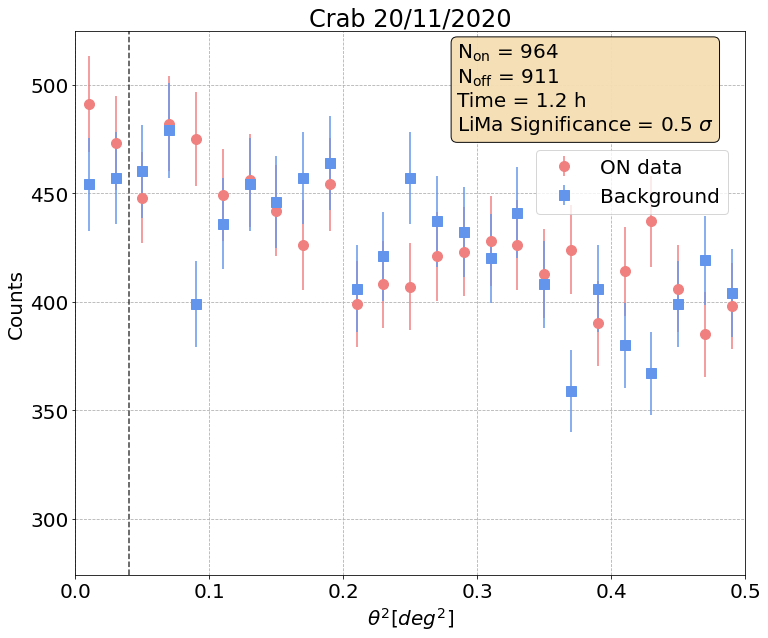

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.errorbar(bin_center, hist_on, yerr=np.sqrt(hist_on), fmt='o', label='ON data', ms=10, color='lightcoral')
ax.errorbar(bin_center, hist_off, yerr=np.sqrt(hist_off),fmt='s',label='Background', ms=10, color='cornflowerblue')
ax.set_xlim(0, 0.5)
ax.grid(ls='dashed')
ax.axvline(THETA2_GLOBAL_CUT, color='black',ls='--',alpha=0.75)
ax.set_xlabel("$\\theta^{2} [deg^{2}]$")
ax.set_ylabel("Counts")
ax.legend(bbox_to_anchor=(0.99, 0.8))
ax.set_title("Crab 20/11/2020")


txt = ax.text(0.57, 0.98, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

## Plot excess counts

In [16]:
excess=hist_on-hist_off
excess_err=np.sqrt(np.sqrt(excess**2))

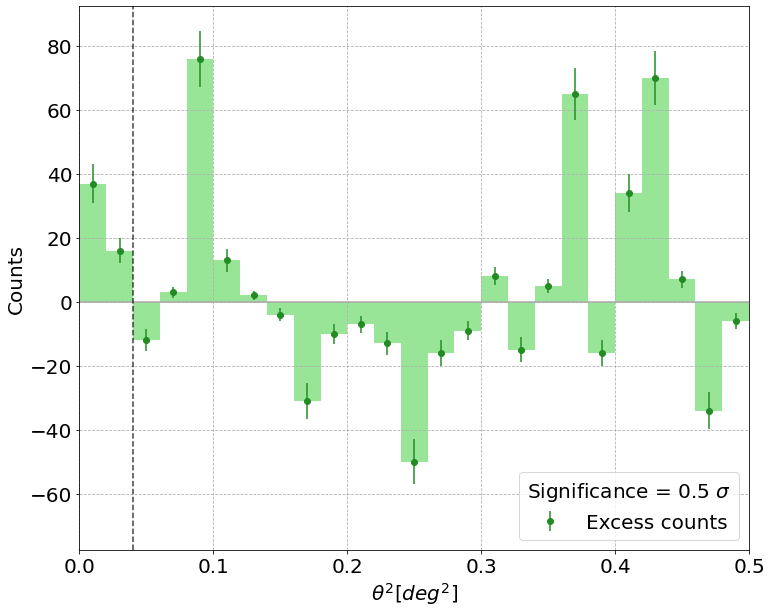

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.errorbar(bin_center, excess, yerr=excess_err,fmt='o',color='forestgreen',label='Excess counts')
ax.bar(bin_edges_on[:-1], excess, width = bin_width, align='edge', color='limegreen',alpha=0.5)
ax.axhline(0, color='darkgray')
ax.set_xlim(0,0.5)
ax.grid()
ax.axvline(THETA2_GLOBAL_CUT, color='black', ls='--', alpha=0.75)
ax.grid(ls='dashed')
ax.set_xlabel("$\\theta^{2} [deg^{2}]$")
ax.set_ylabel("Counts")
ax.legend(title=f'Significance = {significance_lima:.1f} $\sigma$')

# We can make theta2 plots for different bins in energy

## Define the energy binning

In [18]:
log_reco_energy = np.array(selected_data.log_reco_energy)
emin=0.01 * u.TeV
emax=10 * u.TeV
n_bins_energy=3
log_energy = np.linspace(np.log10(emin.to_value()),
                         np.log10(emax.to_value()),
                         n_bins_energy + 1)

## Now calculate the significante and produce a theta2 plot for each energy bin

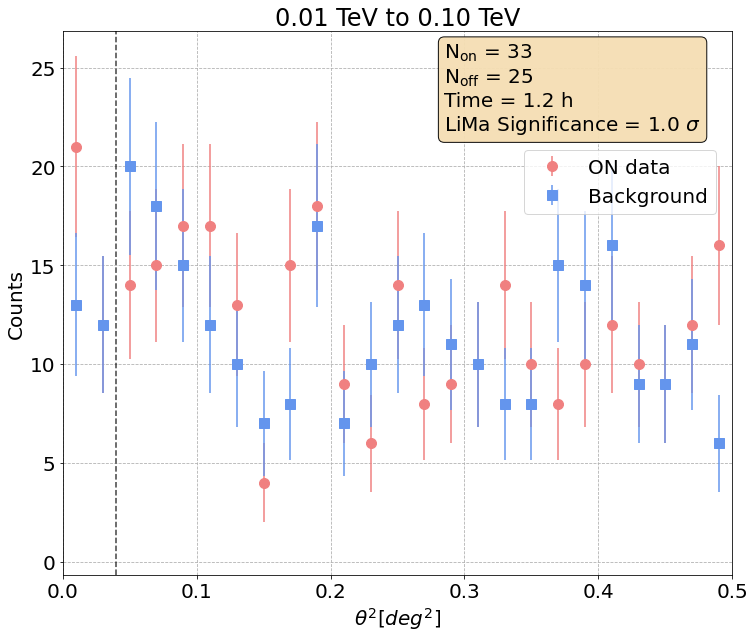

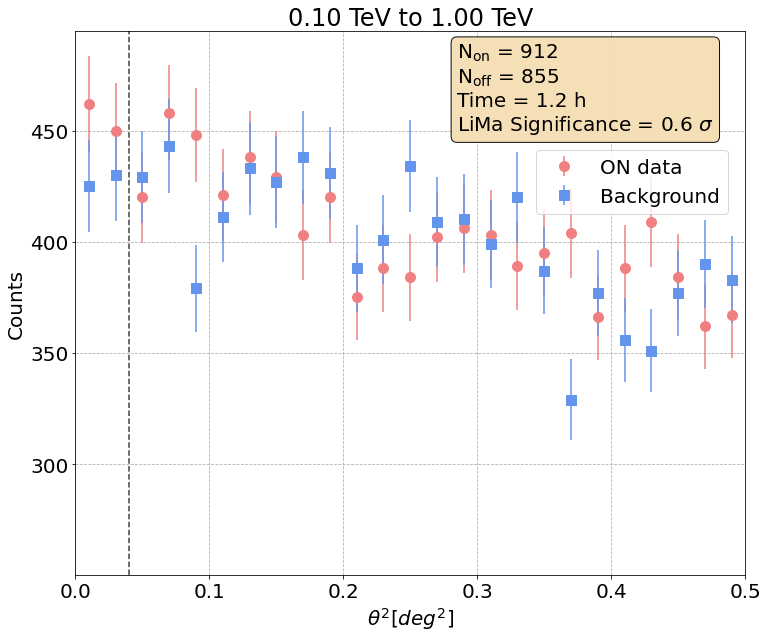

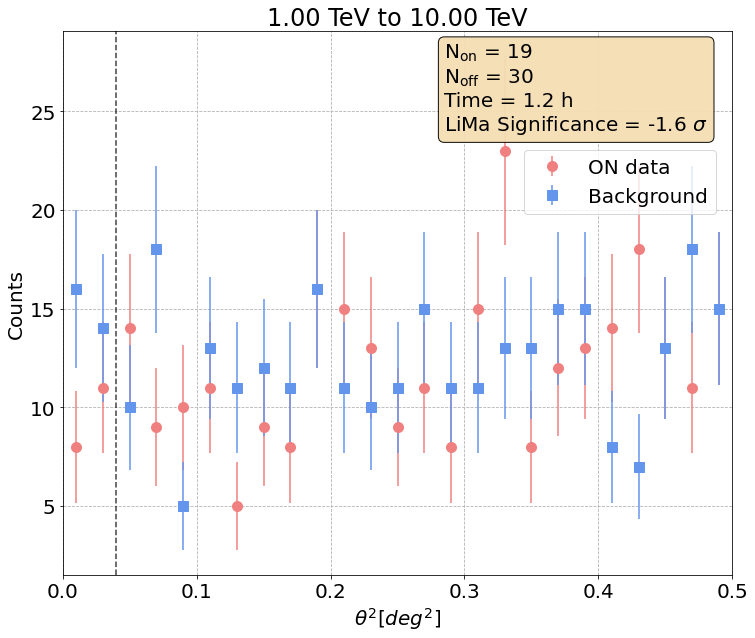

In [19]:
for i in range(n_bins_energy):
    condition_energy_bin= (log_reco_energy < log_energy[i+1]) \
        & (log_reco_energy >= log_energy[i])
    data_bin=selected_data[condition_energy_bin]
    theta2_on = np.array(compute_theta2(data_bin, (true_source_position[0][condition_energy_bin], true_source_position[1][condition_energy_bin])))
    theta2_off = np.array(compute_theta2(data_bin, (off_source_position[0][condition_energy_bin], off_source_position[1][condition_energy_bin])))
    
    hist_on, bin_edges_on=np.histogram(theta2_on,density=False, bins=nbins, range=theta2_range)
    hist_off, bin_edges_off=np.histogram(theta2_off, density=False, bins=nbins, range=theta2_range)

    bin_width=bin_edges_on[1]-bin_edges_off[0]
    bin_center=bin_edges_on[:-1]+(bin_width/2)
    N_on = np.sum(hist_on[bin_edges_on[1:]<=THETA2_GLOBAL_CUT])
    N_off = np.sum(hist_off[bin_edges_off[1:]<=THETA2_GLOBAL_CUT])

    idx_min = (np.abs(bin_edges_on - norm_range_theta2_min)).argmin()
    idx_max = (np.abs(bin_edges_on - norm_range_theta2_max)).argmin()

    Non_norm = np.sum(hist_on[idx_min:idx_max])
    Noff_norm = np.sum(hist_off[idx_min:idx_max])

    alpha = Noff_norm / Non_norm

    stat = WStatCountsStatistic(n_on=N_on, n_off=N_off, alpha=alpha)
    significance_lima = stat.sqrt_ts

    textstr = r'N$_{{\rm on}}$ = {:.0f} '\
            f'\n'\
            r'N$_{{\rm off}}$ = {:.0f} '\
            f'\n'\
            r'Time = {:.1f}'\
            f'\n'\
            r'LiMa Significance = {:.1f} $\sigma$ '.format(N_on,
                                                      N_off,
                                                      obstime_real.to(u.h),
                                                      significance_lima)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.95)
    
    fig, ax = plt.subplots(figsize=(12, 10))

    ax.errorbar(bin_center, hist_on, yerr=np.sqrt(hist_on), fmt='o', label='ON data', ms=10, color='lightcoral')
    ax.errorbar(bin_center, hist_off, yerr=np.sqrt(hist_off),fmt='s',label='Background', ms=10, color='cornflowerblue')
    ax.set_xlim(0, 0.5)
    ax.grid(ls='dashed')
    ax.axvline(THETA2_GLOBAL_CUT, color='black',ls='--',alpha=0.75)
    ax.set_xlabel("$\\theta^{2} [deg^{2}]$")
    ax.set_ylabel("Counts")
    ax.legend(bbox_to_anchor=(0.99, 0.8))
    ax.set_title(r'{:.2f} TeV to {:.2f} TeV'.format(10**log_energy[i], 10**log_energy[i+1]))


    txt = ax.text(0.57, 0.98, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

## Plot the position of the selected events

### In camera coordinates

Text(0, 0.5, 'y (m)')

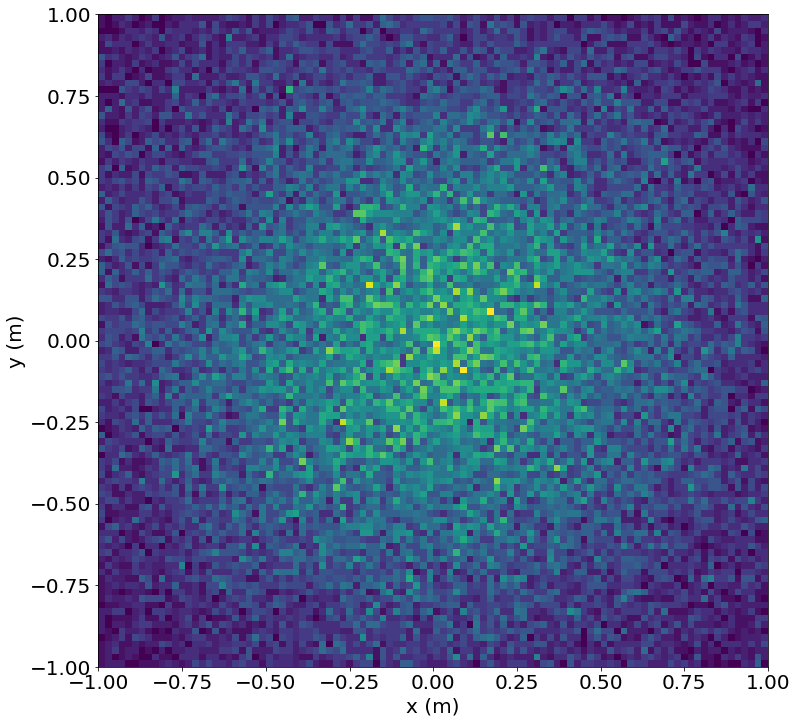

In [20]:
fig, ax = plt.subplots(figsize=(12, 12))

skymap=ax.hist2d(selected_data['reco_src_x'], 
           selected_data['reco_src_y'], bins=100, 
           range=[(-1,1), (-1,1)])
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")


You can see the wobble positions if you use one more than one run

### In Sky coordinates

In [21]:
location = EarthLocation.from_geodetic(-17.89139 * u.deg, 28.76139 * u.deg, 2184 * u.m) #Location of LST1
obstime = pd.to_datetime(selected_data["dragon_time"], unit="s")
horizon_frame = AltAz(location=location, obstime=obstime)

In [22]:
%%time
pointing_alt = u.Quantity(selected_data["alt_tel"], u.rad, copy=False)
pointing_az = u.Quantity(selected_data["az_tel"], u.rad, copy=False)
pointing_direction=SkyCoord(alt=clip_alt(pointing_alt), az=pointing_az, frame=horizon_frame)
camera_frame = CameraFrame(focal_length=28 * u.m,
                           telescope_pointing=pointing_direction,
                           obstime=obstime,
                           location=location)  

CPU times: user 18.6 s, sys: 53.2 ms, total: 18.6 s
Wall time: 18.6 s


In [23]:
camera_coords = SkyCoord(x=selected_data['reco_src_x'], y=selected_data['reco_src_y'], frame=camera_frame, unit=(u.m, u.m))

In [24]:
radec_coords=camera_coords.transform_to(frame=ICRS)

Text(0, 0.5, 'Declination (deg)')

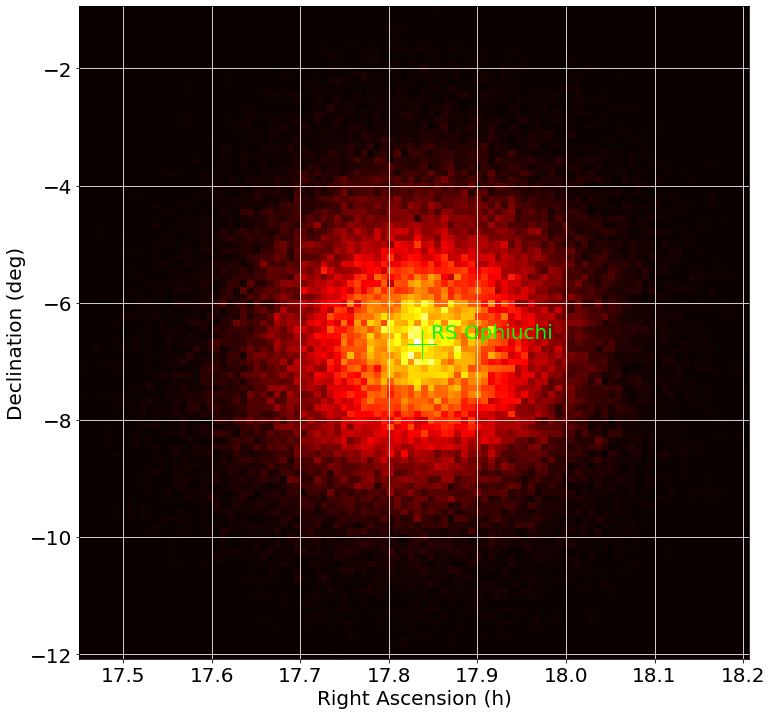

In [26]:
fig, ax = plt.subplots(figsize=(12, 12))
radec_skymap=plt.hist2d(radec_coords.ra.to_value(u.hourangle), 
           radec_coords.dec.value, 
           bins=100, cmap='hot')
ax.plot(coordinates[0].ra.to_value(u.hourangle), coordinates[0].dec.value, marker='+', 
        color='lime', markersize=30)
ax.text(coordinates[0].ra.to_value(u.hourangle)+0.01, coordinates[0].dec.value+0.1, 'RS Ophiuchi', color='lime')
ax.grid(color='white')
ax.set_xlabel("Right Ascension (h)")
ax.set_ylabel("Declination (deg)")